In [356]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from datasets.graph import draw_sample
import torch

model_fname = '/home/lagray/hgcal_ldrd/checkpoints/model_checkpoint_UnnormalizedEdgeNet_239246_5d394296c0_lagray.best.pth.tar'

test_fname = '/home/lagray/training_data/single_taus/test/processed/data_41.pt'

#weird stuff
#'/home/lagray/training_data/single_taus/test/processed/data_39.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_41.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_2.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_26.pt'

In [357]:
from models.UnnormalizedEdgeNet import UnnormalizedEdgeNet

mdl = UnnormalizedEdgeNet(input_dim=5, hidden_dim=64, output_dim=4, n_iters=6)

mdl.load_state_dict(torch.load(model_fname, map_location=torch.device('cpu'))['model'])
mdl.eval()

UnnormalizedEdgeNet(
  (inputnet): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=4, bias=True)
    (5): LogSoftmax()
  )
  (nodenetwork0): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=101, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  ))
  (nodenetwork1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=101, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  ))
  (nodenetwork2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_feat

In [358]:
data = torch.load(test_fname)

In [359]:
pred_edges = mdl(data).detach()
pred_edges_np = pred_edges.numpy()

In [360]:
print(np.unique(np.argmax(pred_edges_np,axis=-1), return_counts=True))
print(torch.unique(data.y, return_counts=True))

(array([0, 1, 2]), array([553139,  29484,   9745]))
(tensor([0, 1]), tensor([548380,  43988]))


In [364]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import tqdm

def draw_sample(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out > 0
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]    
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
    
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    e_max = np.max(X[:,4])
    e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    ax0.scatter(X[:,0], X[:,2], s=(e_normed), c='k')
    ax1.scatter(X[:,1], X[:,2], s=(e_normed), c='k')
        
        
    lines0 = []
    lines1 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm.tqdm(range(good_outs.shape[0])):
            
            lines0.append([(feats_o[j,0], feats_o[j,2]),(feats_i[j,0], feats_i[j,2])])
            lines1.append([(feats_o[j,1], feats_o[j,2]),(feats_i[j,1], feats_i[j,2])])
            colors.append(color_map[good_outs[j]])
            
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()
    return fig;

In [365]:
#print()

X = data.x.numpy()
index = data.edge_index.numpy().T
Ro = index[:,0]
Ri = index[:,1]
y = data.y.numpy()

out = np.argmax(pred_edges_np,axis=-1)


100%|██████████| 43988/43988 [00:00<00:00, 349108.01it/s]


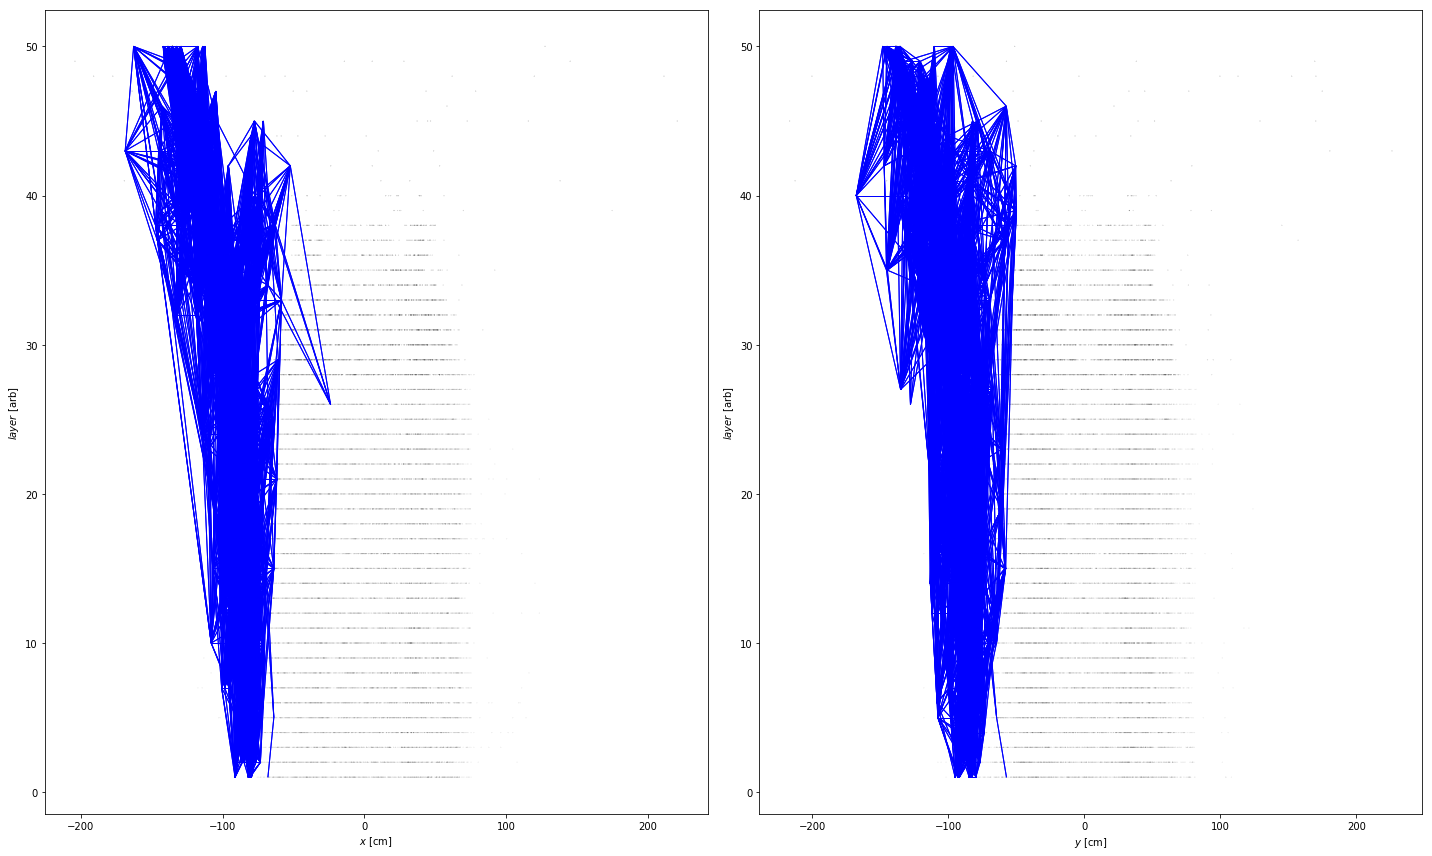

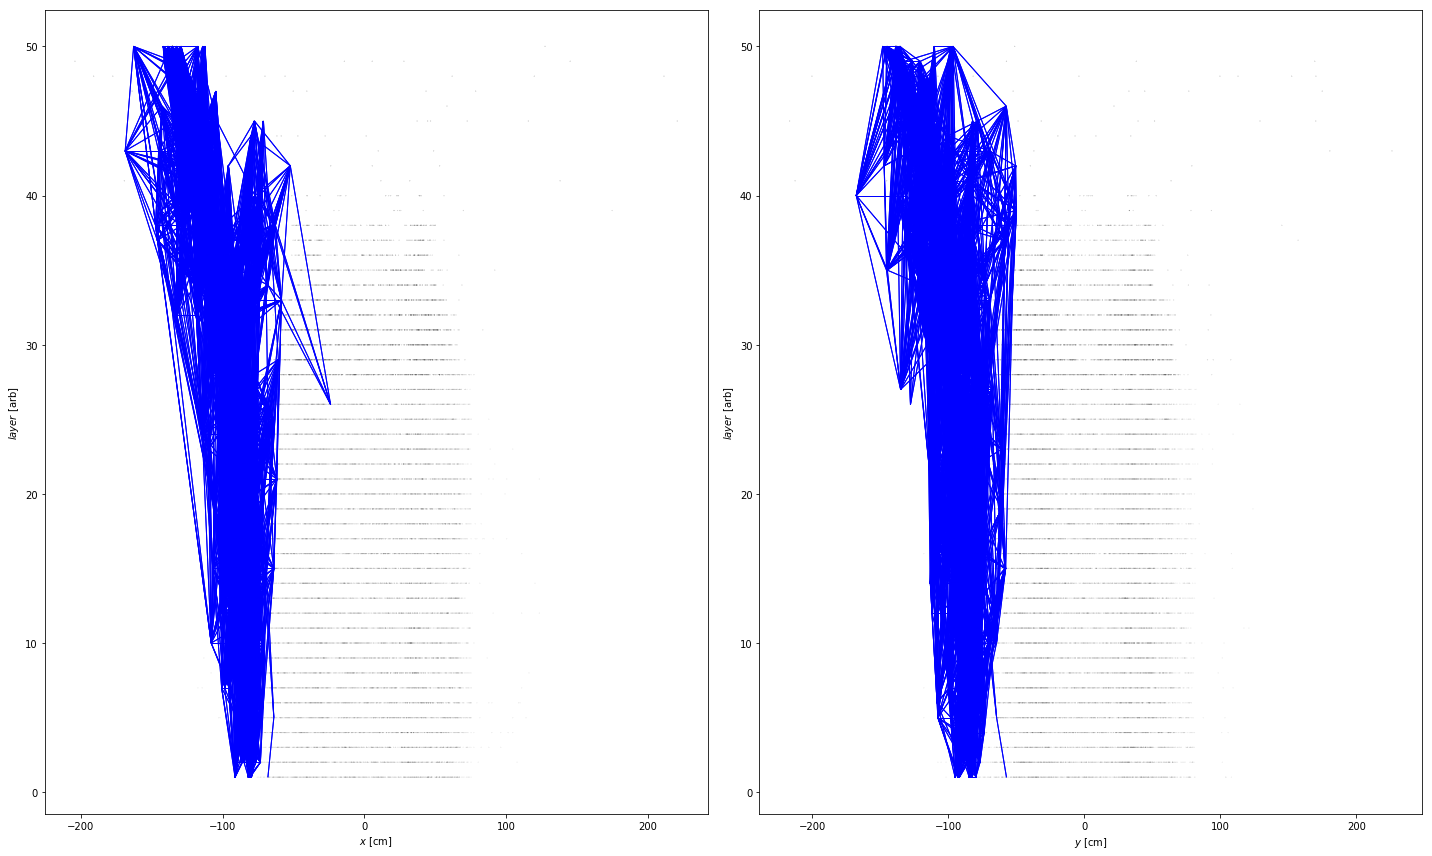

In [366]:
draw_sample(X, Ri, Ro, y, y)

100%|██████████| 39229/39229 [00:00<00:00, 374620.86it/s]


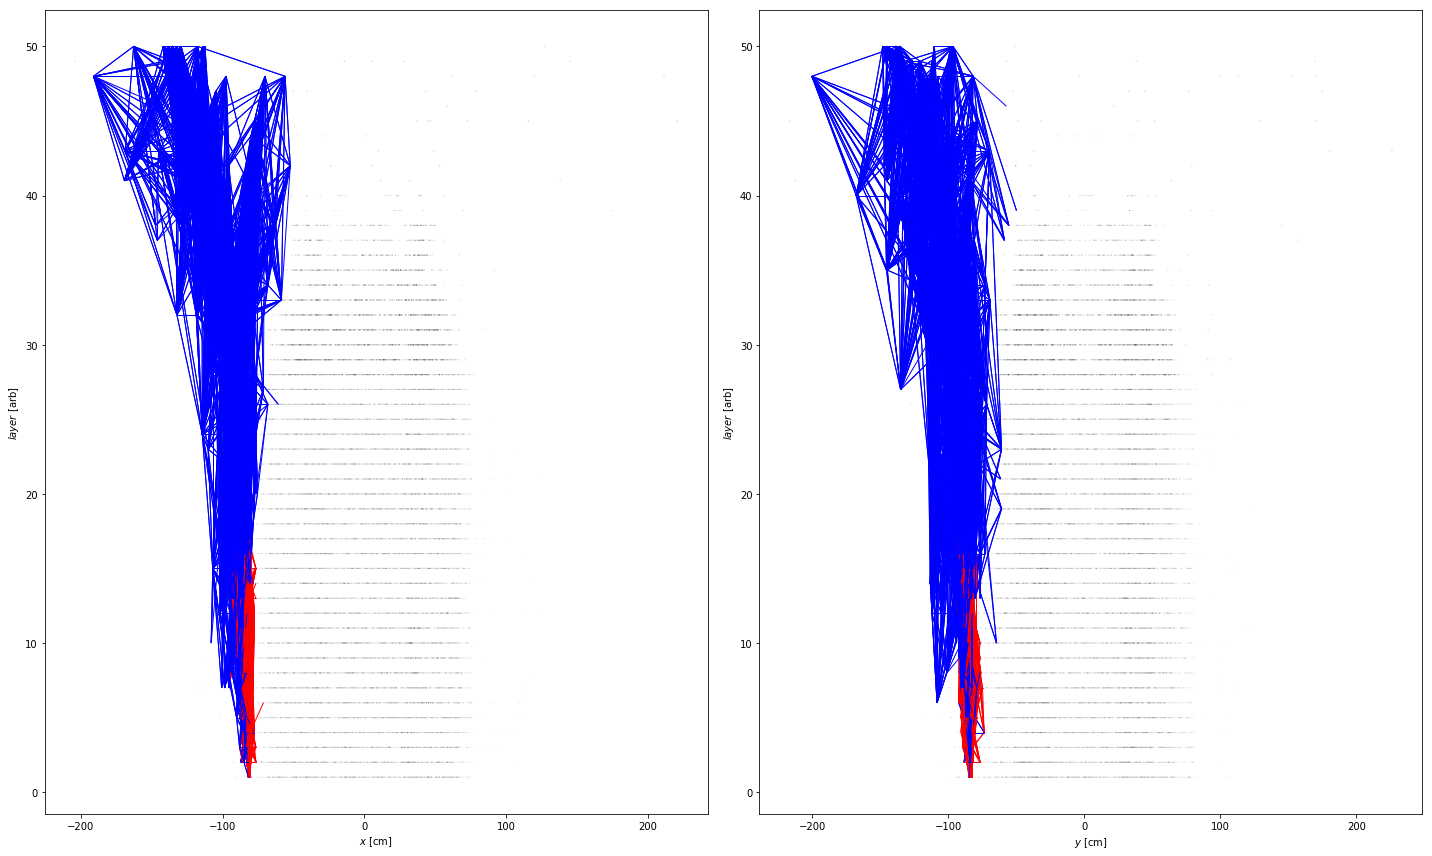

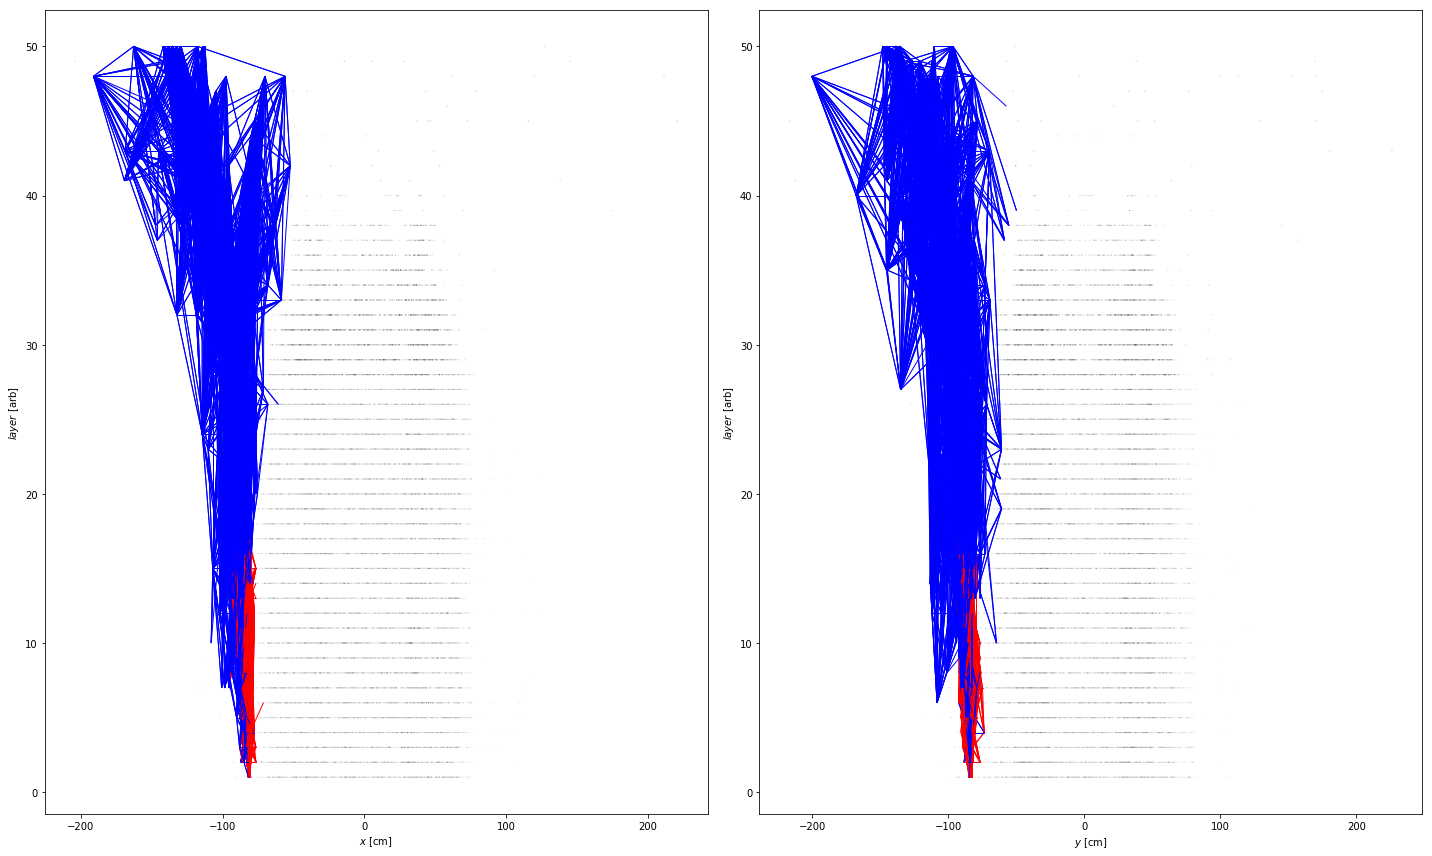

In [367]:
draw_sample(X, Ri, Ro, y, out)

(592368, 4)

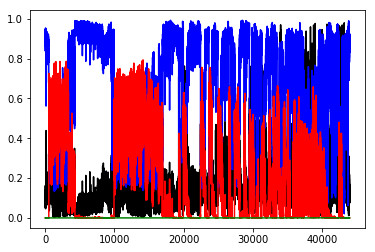

In [368]:
thecats = np.argmax(pred_edges_np,axis=-1)
plt.plot(np.exp(pred_edges_np[:,0][y != 0]),color='black')
plt.plot(np.exp(pred_edges_np[:,1][y != 0]),color='blue')
plt.plot(np.exp(pred_edges_np[:,2][y != 0]),color='red')
plt.plot(np.exp(pred_edges_np[:,3][y != 0]),color='green')
pred_edges_np.shape

39 39


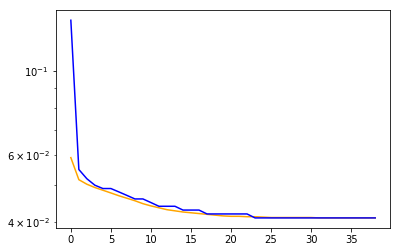

In [301]:
validation_loss = np.array([0.0591,0.0517,0.0503,0.0493,0.0485,0.0477,0.0469,0.0462,0.0455,0.0447,0.0441,0.0436,0.0431,0.0428,0.0425,0.0423,0.0421,0.0419,0.0417,0.0415,0.0414,0.0414,0.0413,0.0413,0.0412,0.0411,0.0411,0.0411,0.0411,0.0411,0.0411,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410,0.0410])
training_loss = np.array([0.136,0.055,0.052,0.050,0.049,0.049,0.048,0.047,0.046,0.046,0.045,0.044,0.044,0.044,0.043,0.043,0.043,0.042,0.042,0.042,0.042,0.042,0.042,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041,0.041])
learning_rate = np.concatenate((np.full(18, 1e-4),np.full(24-18, 2e-5),
                                np.full(30-24, 4e-6),np.full(36-30,8e-7),
                                np.full(39-36, 1.6e-7)))
#Epoch    18: reducing learning rate of group 0 to 2.0000e-05.
#Epoch    24: reducing learning rate of group 0 to 4.0000e-06.
#Epoch    30: reducing learning rate of group 0 to 8.0000e-07.
#Epoch    36: reducing learning rate of group 0 to 1.6000e-07.

                               
                               
print(validation_loss.size, training_loss.size)

plt.yscale('log')
plt.plot(validation_loss, color='orange')
plt.plot(training_loss, color='blue')


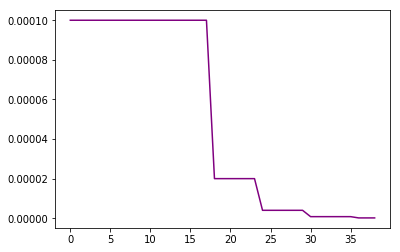

In [302]:
plt.plot(learning_rate, color='purple')